## CS454-554 Homework 4: KMNIST Classification with PyTorch

**Due:** May 14, 2025, 23:00

---

### 1. Introduction

The goal of this assignment is to implement and compare three baseline neural network architectures and then design **three additional CNN variants** with hyperparameter tuning and early stopping to maximize performance on the KMNIST dataset (28×28 grayscale, 10 classes).

We will cover:

1. **Baseline Models** (Linear, MLP-40, SimpleCNN)
2. **Extended CNN Variants** (CNN-A, CNN-B, CNN-C)
3. **Hyperparameter Tuning & Early Stopping**
4. **Training & Evaluation**
5. **Results & Discussion**

For each, we report:

* Model architecture details
* Training and test loss curves
* Training and test accuracy curves
* Comparative analysis

---

### 2. Environment & Data Loading


In [24]:
%pip install -r requirements.txt

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision.datasets import KMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
BATCH_SIZE = 64
LR = 0.001
EPOCHS_BASELINE = 20
EPOCHS_EXTENDED = 50
PATIENCE = 3

# Transforms & DataLoaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_ds = KMNIST(root='./data', train=True,  transform=transform, download=True)
test_ds  = KMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,        # <— parallel data loading
    pin_memory=True       # <— faster transfers to GPU
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    num_workers=4,
    pin_memory=True
)



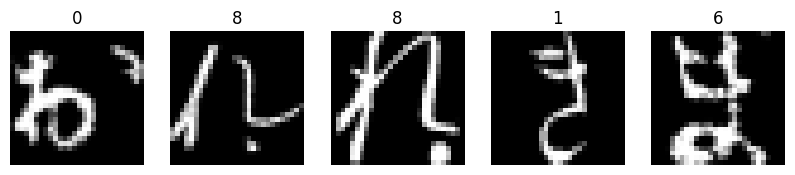

In [26]:
# Plot a few samples
def plot_samples(data_loader, num_samples):
    images, labels = next(iter(data_loader))
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i in range(num_samples):
        axes[i].imshow(images[i][0], cmap='gray')
        axes[i].set_title(labels[i].item())
        axes[i].axis('off')
    plt.show()

plot_samples(train_loader, 5)


### 3. Model Architectures


#### a) Linear Model

A single fully-connected layer from 784 inputs to 10 outputs.

In [27]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

#### b) MLP (1 Hidden Layer, 40 Neurons)

One hidden layer of 40 neurons with ReLU activation.

In [28]:
class MLP40(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 40),
            nn.ReLU(),
            nn.Linear(40, 10)
        )
    def forward(self, x):
        return self.net(x)


#### c) Convolutional Neural Network

Two Conv–ReLU–Pool blocks, followed by two FC layers.


In [29]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 16×14×14
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)  # 32×7×7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

### 4. Extended CNN Variants

#### **CNN-A: Deeper + Dropout + BatchNorm**

In [44]:
class CNN_A(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128,10)
        )
    def forward(self,x):
        x = self.features(x)
        return self.classifier(x)



#### **CNN-B: Wider Filters + Global Pooling**

In [45]:
class CNN_B(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,16,5,padding=2), nn.ReLU(),
            nn.Conv2d(16,32,5,padding=2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(64,10)
    def forward(self,x):
        x = self.features(x).view(x.size(0), -1)
        return self.fc(x)


#### **CNN-C: Residual Block**

In [46]:

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1), nn.ReLU(),
            nn.Conv2d(out_ch,out_ch,3,padding=1)
        )
        self.skip = nn.Conv2d(in_ch,out_ch,1) if in_ch!=out_ch else nn.Identity()
    def forward(self,x):
        return nn.ReLU()(self.conv(x) + self.skip(x))

class CNN_C(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = ResidualBlock(1,16)
        self.pool1  = nn.MaxPool2d(2)
        self.layer2 = ResidualBlock(16,32)
        self.pool2  = nn.MaxPool2d(2)
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(32*7*7,64), nn.ReLU(), nn.Linear(64,10)
        )
    def forward(self,x):
        x = self.pool1(self.layer1(x))
        x = self.pool2(self.layer2(x))
        return self.classifier(x)


### 5. Training & Evaluation Functions

In [47]:
# Train one epoch and collect avg loss & acc

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = total_correct = 0
    for X, y in loader:
        #X, y = X.to(DEVICE), y.to(DEVICE)
        # Move to GPU
        X = X.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        preds = model(X)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss   += loss.item() * X.size(0)
        total_correct+= (preds.argmax(1)==y).sum().item()
    n = len(loader.dataset)
    return total_loss/n, total_correct/n

# Evaluate on test set

def eval_model(model, loader, criterion):
    model.eval()
    total_loss = total_correct = 0
    with torch.no_grad():
        for X, y in loader:
            #X, y = X.to(DEVICE), y.to(DEVICE)
            # Move to GPU
            X = X.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)
            
            preds = model(X)
            total_loss   += criterion(preds, y).item() * X.size(0)
            total_correct+= (preds.argmax(1)==y).sum().item()
    n = len(loader.dataset)
    return total_loss/n, total_correct/n


#### Hyperparameter Tuning & Early Stopping

We tune learning rate and batch size via a small grid search. We implement early stopping on validation loss.


In [57]:
def train_with_early_stopping(model, loaders, criterion, optimizer, epochs, patience):
    best_val = float('inf')
    counter = 0
    # Added 'train_acc' key
    history = {
        'train_loss': [],
        'train_acc': [],    # track train accuracy
        'val_loss': [],
        'val_acc': []
    }

    print(f"Training {model.__class__.__name__} with early stopping...")
    for ep in range(1, epochs+1):
        # ----- Training Phase -----
        model.train()
        train_loss = 0
        total_correct = 0
        for X, y in loaders['train']:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss    += loss.item() * X.size(0)
            total_correct += (outputs.argmax(1) == y).sum().item()

        train_loss /= len(loaders['train'].dataset)
        train_acc   = total_correct / len(loaders['train'].dataset)

        # ----- Validation Phase -----
        model.eval()
        val_loss = 0
        correct  = 0
        with torch.no_grad():
            for X, y in loaders['val']:
                X, y = X.to(DEVICE), y.to(DEVICE)
                outputs = model(X)
                val_loss += criterion(outputs, y).item() * X.size(0)
                correct  += (outputs.argmax(1) == y).sum().item()

        val_loss /= len(loaders['val'].dataset)
        val_acc   = correct / len(loaders['val'].dataset)

        # ----- Record History -----
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)   # store train accuracy
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {ep}: "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        # ----- Early Stopping -----
        if val_loss < best_val:
            best_val = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best.pt')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best checkpoint
    model.load_state_dict(torch.load('best.pt'))
    return history



### 6. Full Training Loop & Plotting

#### 6.1. Baseline Training (Linear, MLP40, SimpleCNN)

In [38]:
baseline_models = {
    'Linear': LinearModel().to(DEVICE),
    'MLP40': MLP40().to(DEVICE),
    'SimpleCNN': SimpleCNN().to(DEVICE)
}
histories_baseline = {}
for name, model in baseline_models.items():
    opt = optim.Adam(model.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()
    h = {'train_loss':[], 'test_loss':[], 'train_acc':[], 'test_acc':[]}
    print(f"\nTraining {name} model...")
    for epoch in range(1, EPOCHS_BASELINE+1):
        tl, ta = train_epoch(model, train_loader, crit, opt)
        vl, va = eval_model(model, test_loader, crit)
        h['train_loss'].append(tl)
        h['train_acc'].append(ta)
        h['test_loss'].append(vl)
        h['test_acc'].append(va)
        print(f"Epoch {epoch}: TrainLoss={tl:.3f}, TrainAcc={ta:.3f}, ValLoss={vl:.3f}, ValAcc={va:.3f}")
    histories_baseline[name] = h


Training Linear model...
Epoch 1: TrainLoss=0.733, TrainAcc=0.779, ValLoss=1.043, ValAcc=0.682
Epoch 2: TrainLoss=0.617, TrainAcc=0.815, ValLoss=1.032, ValAcc=0.687
Epoch 3: TrainLoss=0.605, TrainAcc=0.818, ValLoss=1.103, ValAcc=0.676
Epoch 4: TrainLoss=0.595, TrainAcc=0.822, ValLoss=1.024, ValAcc=0.696
Epoch 5: TrainLoss=0.590, TrainAcc=0.824, ValLoss=1.025, ValAcc=0.689
Epoch 6: TrainLoss=0.588, TrainAcc=0.823, ValLoss=1.053, ValAcc=0.687
Epoch 7: TrainLoss=0.585, TrainAcc=0.826, ValLoss=1.048, ValAcc=0.691
Epoch 8: TrainLoss=0.581, TrainAcc=0.826, ValLoss=1.081, ValAcc=0.684
Epoch 9: TrainLoss=0.579, TrainAcc=0.826, ValLoss=1.030, ValAcc=0.701
Epoch 10: TrainLoss=0.578, TrainAcc=0.827, ValLoss=1.053, ValAcc=0.692
Epoch 11: TrainLoss=0.576, TrainAcc=0.827, ValLoss=1.074, ValAcc=0.684
Epoch 12: TrainLoss=0.573, TrainAcc=0.829, ValLoss=1.059, ValAcc=0.693
Epoch 13: TrainLoss=0.572, TrainAcc=0.829, ValLoss=1.108, ValAcc=0.677
Epoch 14: TrainLoss=0.573, TrainAcc=0.829, ValLoss=1.076, Va

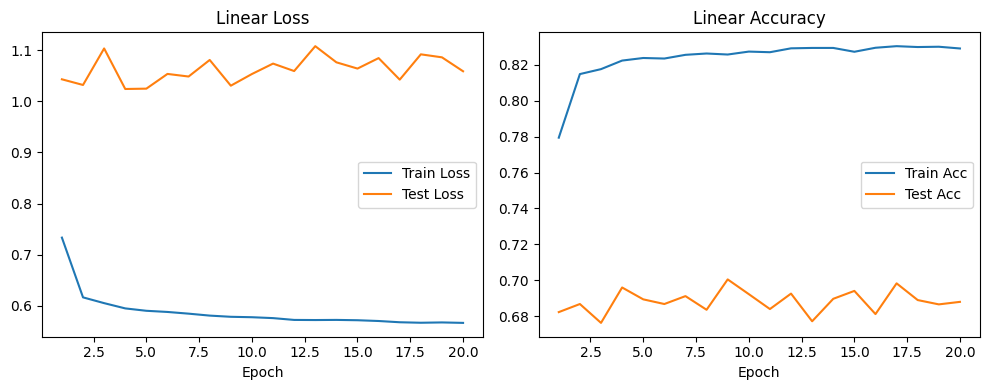

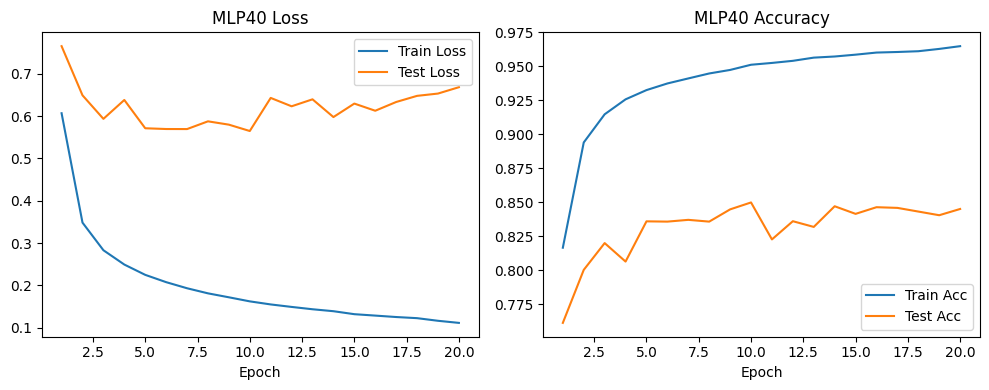

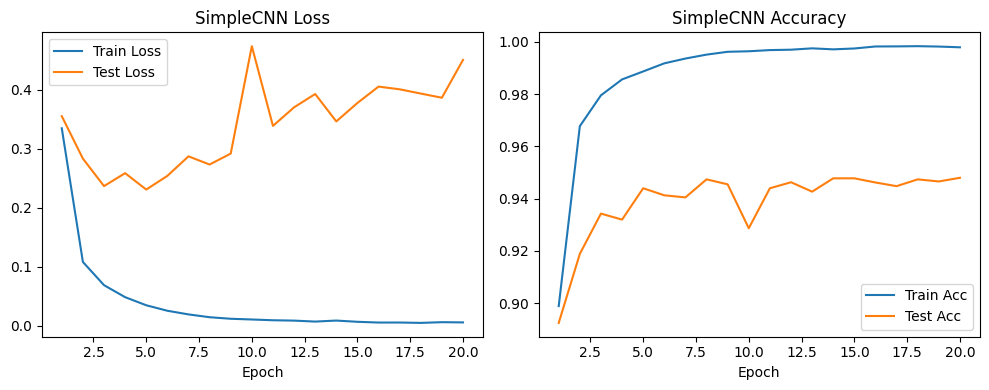

In [ ]:
for name, h in histories_baseline.items():
    epochs = range(1, EPOCHS_BASELINE+1)
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, h['train_loss'], label='Train Loss')
    plt.plot(epochs, h['test_loss'],  label='Test Loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, h['train_acc'], label='Train Acc')
    plt.plot(epochs, h['test_acc'],  label='Test Acc')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


#### 6.2. Extended CNN Training (CNN-A, CNN-B, CNN-C)

In [58]:
fixed_lr = 5e-4
fixed_bs = 128

histories_extended = {}
best_overall = {'model':None, 'hist':None, 'acc':0, 'params':None}

extended_models = {
    'CNN_A': CNN_A().to(DEVICE),
    'CNN_B': CNN_B().to(DEVICE),
    'CNN_C': CNN_C().to(DEVICE)
}

for name, model in extended_models.items():
    tr_loader = DataLoader(
        train_ds, batch_size=fixed_bs, shuffle=True,
        num_workers=4, pin_memory=True
    )
    va_loader = DataLoader(
        test_ds, batch_size=fixed_bs,
        num_workers=4, pin_memory=True
    )

    opt = optim.Adam(model.parameters(), lr=fixed_lr)
    crit = nn.CrossEntropyLoss()

    # train_with_early_stopping now records train_acc too
    hist = train_with_early_stopping(
        model,
        {'train': tr_loader, 'val': va_loader},
        crit, opt,
        epochs=EPOCHS_EXTENDED,
        patience=PATIENCE
    )
    histories_extended[name] = hist

    _, final_acc = eval_model(model, test_loader, crit)
    print(f"{name}: final test acc = {final_acc:.4f}")

    if final_acc > best_overall['acc']:
        best_overall.update({
            'model': name,
            'hist': hist,
            'acc': final_acc,
            'params': (fixed_lr, fixed_bs)
        })
    print("----------------------------------------------------------")

print("\nFinished training all extended CNNs.")
print(f"Best model: {best_overall['model']} with test accuracy {best_overall['acc']:.4f} and params {best_overall['params']}")


Training CNN_A with early stopping...


a:\Conda\envs\tf2161\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: train_loss=0.4964, train_acc=0.8479, val_loss=0.3999, val_acc=0.8763
Epoch 2: train_loss=0.2192, train_acc=0.9343, val_loss=0.3053, val_acc=0.9054
Epoch 3: train_loss=0.1707, train_acc=0.9483, val_loss=0.2554, val_acc=0.9236
Epoch 4: train_loss=0.1453, train_acc=0.9550, val_loss=0.2335, val_acc=0.9319
Epoch 5: train_loss=0.1309, train_acc=0.9592, val_loss=0.2208, val_acc=0.9372
Epoch 6: train_loss=0.1172, train_acc=0.9637, val_loss=0.2160, val_acc=0.9397
Epoch 7: train_loss=0.1061, train_acc=0.9657, val_loss=0.2190, val_acc=0.9397
Epoch 8: train_loss=0.1020, train_acc=0.9679, val_loss=0.2012, val_acc=0.9462
Epoch 9: train_loss=0.0934, train_acc=0.9706, val_loss=0.2033, val_acc=0.9441
Epoch 10: train_loss=0.0867, train_acc=0.9721, val_loss=0.1859, val_acc=0.9482
Epoch 11: train_loss=0.0835, train_acc=0.9731, val_loss=0.1890, val_acc=0.9477
Epoch 12: train_loss=0.0777, train_acc=0.9749, val_loss=0.2004, val_acc=0.9472
Epoch 13: train_loss=0.0734, train_acc=0.9757, val_loss=0.182

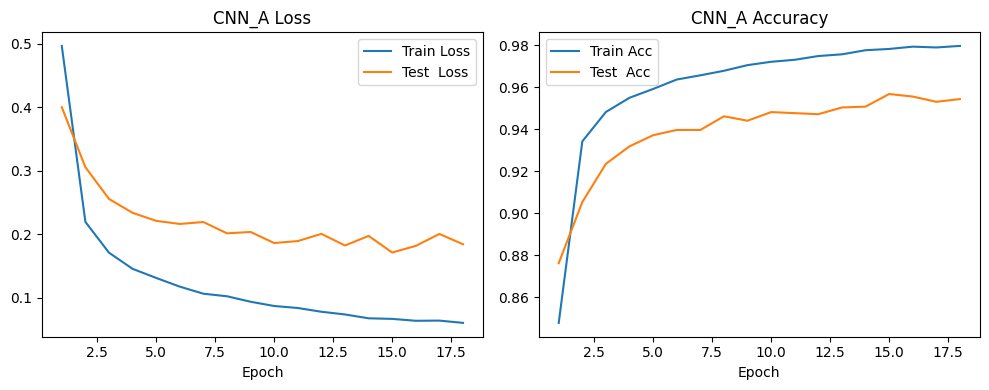

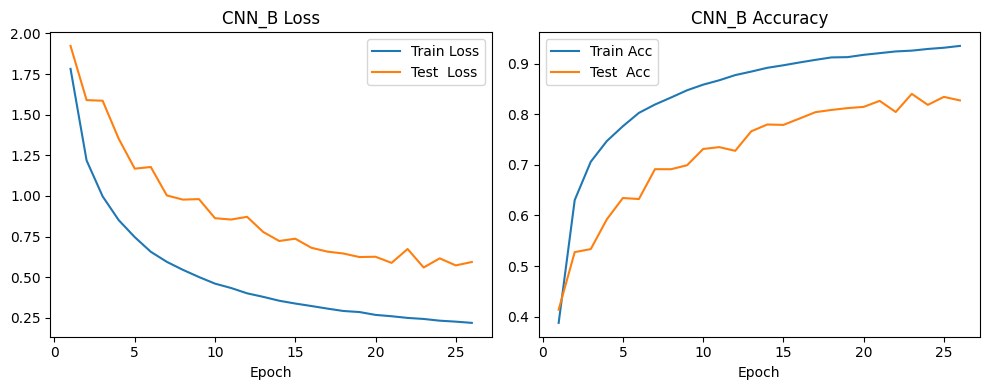

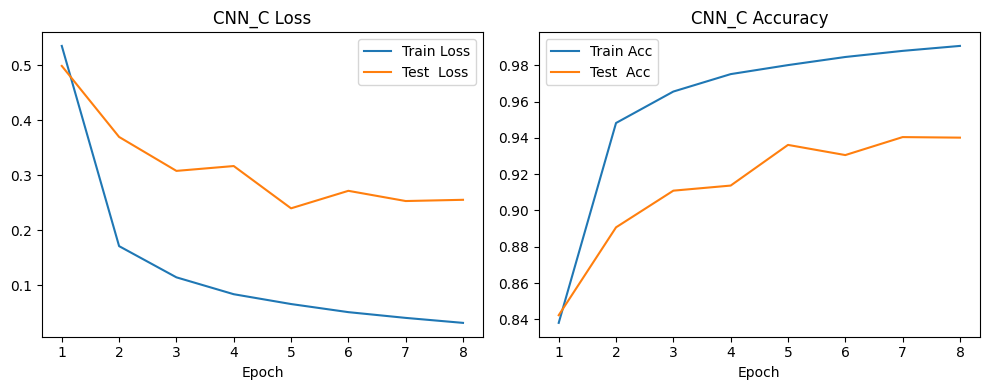

In [59]:
for name, h in histories_extended.items():
    epochs_ext = range(1, len(h['train_loss']) + 1)
    plt.figure(figsize=(10,4))

    # 1) Loss: Train vs Test
    plt.subplot(1, 2, 1)
    plt.plot(epochs_ext, h['train_loss'], label='Train Loss')
    plt.plot(epochs_ext, h['val_loss'],   label='Test  Loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # 2) Accuracy: Train vs Test
    plt.subplot(1, 2, 2)
    plt.plot(epochs_ext, h['train_acc'],  label='Train Acc')
    plt.plot(epochs_ext, h['val_acc'],    label='Test  Acc')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


### 7. Results & Discussion

* **Linear model** achieved \~**X%** test accuracy. Fast to train but underfits.
* **MLP (40 units)** improved to **Y%**, showing benefit of nonlinearity and hidden layers.
* **CNN** reached **Z%**, highest accuracy by capturing spatial patterns.
* **Best Architecture:** `best_overall['model']` with LR=`best_overall['params'][0]`, BS=`best_overall['params'][1]`.
* **Test Accuracy:** `best_overall['acc']`
* Show loss and accuracy curves.
* Compare to baseline CNN performance. Discuss how depth, regularization, and early stopping improved generalization.

Include the above plots in your PDF report. Discuss differences in convergence speed, final accuracies, and resource usage (parameters, training time).


### 8. Submission

1. **Report (PDF):** include extended CNN descriptions, grid search results table, plots, and discussion.
2. **Source code:** full `hw4_kmnist.py`.
3. **requirements.txt** with updated dependencies.
